In [1]:
from datasets import load_dataset
from fim.utils.interpolator import KernelInterpolator
from fim.models.hawkes import FIMHawkes
import torch
from matplotlib import pyplot as plt
from functools import partial

In [18]:
split = "train"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_of_processes = 3

In [19]:
data = load_dataset("FIM4Science/hawkes-synthetic-short-scale-single-process", "train_process_8")
data.set_format(type='torch')

In [33]:
kernel_interpolator = KernelInterpolator(data[split][0]['target_kernel_grids'].to(device), data[split][0]['target_kernel_evaluations'].to(device), mode="interpolate", out_of_bounds_value=0)
intensity_fn = partial(FIMHawkes.intentsity, kernel=kernel_interpolator, base_intensity=data[split][0]["target_base_intensities"].to(device))

t_values = torch.stack([torch.linspace(0, data[split][i]['target_intensity_times'].max(), 1200, device=device) for i in range(num_of_processes)])
intensities = intensity_fn(t_values.unsqueeze(-1), data[split][:num_of_processes]['time_since_start'].to(device))



Query points are out of bounds of the grid points. The kernel values for these points will be set to 0.


In [34]:
t_values.shape

torch.Size([3, 1200])

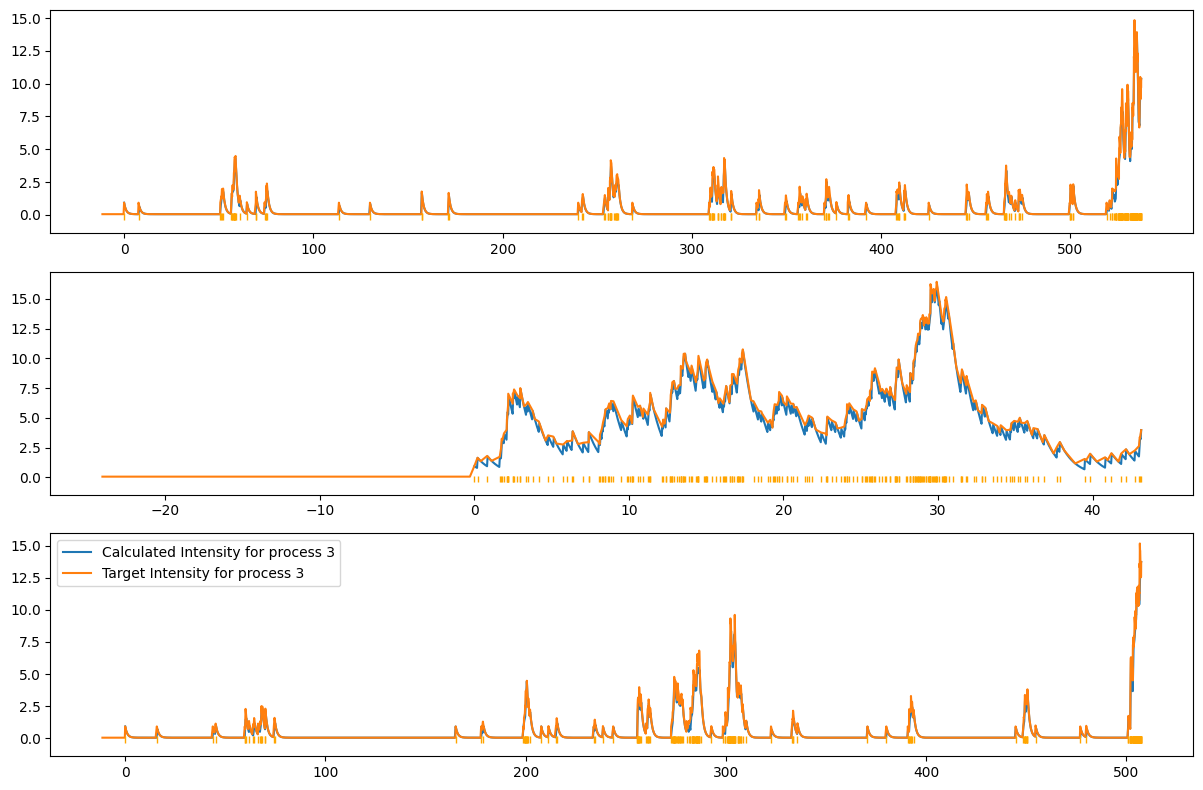

In [46]:
# Plot events
fig, ax = plt.subplots(num_of_processes, 1, figsize=(12, 8))
axes = ax.flatten()
for i in range(num_of_processes):
   for k in range(intensities.shape[2]):
      axes[i].plot(t_values[i].cpu().squeeze(), intensities[i, :, :, k].cpu().squeeze(), label=f'Calculated Intensity for process {i+1}')
      axes[i].plot(data[split][i]['target_intensity_times'].cpu().squeeze(), data[split][i]['target_intensities'][k].cpu().squeeze(), label=f'Target Intensity for process {i+1}')
      time_since_start = data[split][i]['time_since_start'][data[split][i]['type_event'] == k]
      axes[i].eventplot(time_since_start.cpu().squeeze(), color='orange', linelengths=0.5, linewidths=1., lineoffsets=-0.1)
plt.tight_layout()
plt.legend()
plt.show()
